In [1]:
import numpy as np
import pandas as pd 
import random as rd
import datetime
from collections import Counter
import statsmodels.api as sm
from fbprophet import Prophet
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error

In [2]:
sales=pd.read_csv("sales_train.csv")
item_cat=pd.read_csv("item_categories.csv")
item=pd.read_csv("items.csv")
shops=pd.read_csv("shops.csv")

# Getting Datetime Format

In [8]:
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

# Shops and Total Sales

In [4]:
tot_items = dict(sales.groupby(['shop_id'])['item_cnt_day'].sum())

In [5]:
single = sales.loc[sales.date_block_num == 0]
single_items = dict(single.groupby(['shop_id'])['item_cnt_day'].sum())

# Monthly Sales by Shop

In [6]:
monthly_sales = {}
for i in range(0, 34):
    monthly_sales[i] = [0] * 60
for i in range(0,34):
    single = sales.loc[sales.date_block_num == i]
    single_items = dict(single.groupby(['shop_id'])['item_cnt_day'].sum())
    temp = monthly_sales[i]
    for j in list(single_items.keys()):
        temp[j] = single_items[j]

In [7]:
month_data = list(monthly_sales.values())
cols = range(0, 60)

month_df = pd.DataFrame(np.array(month_data),columns=cols)
month_df = month_df.T

# Monthly Sales by Item

In [9]:
main_df = sales.groupby(['date_block_num','shop_id','item_id'], as_index = False).sum()[['date_block_num','shop_id','item_id','item_cnt_day']]
main_df

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1609119,33,59,22087,6.0
1609120,33,59,22088,2.0
1609121,33,59,22091,1.0
1609122,33,59,22100,1.0


# Test Shops

In [10]:
test_df = pd.read_csv('test.csv')
test_shops = list(test_df.shop_id)
test_shops = dict(Counter(test_shops))
test_shops = list(test_shops.keys())
test_df.loc[test_df.shop_id == 5]
len(test_shops)

42

# Stationarity Check

## Seasonal Decmposition

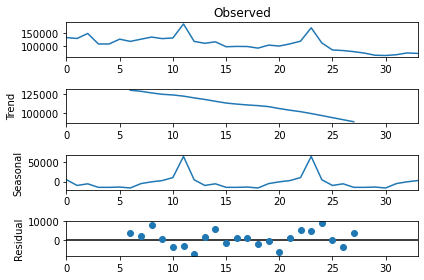

In [11]:
items_monthly=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts_SD = sm.tsa.seasonal_decompose(items_monthly.values,period=12)
fig = ts_SD.plot()

In [13]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
dataList = list(ts['item_cnt_day'])
ts.head()
ts.columns=['ds','y']

In [14]:
from statsmodels.tsa.stattools import adfuller

def stationarity_check(ts_data):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dfuller = adfuller(ts_data, autolag='AIC')
    dfuller_results = pd.Series(dfuller[0:4], index=['Test Statistic','p-value','Lags','Size of Data'])
    for key,value in dfuller[4].items():
        dfuller_results['Critical Value (%s)'%key] = value
    print (dfuller_results)

stationarity_check(sales.groupby(["date_block_num"])["item_cnt_day"].sum())

Results of Dickey-Fuller Test:
Test Statistic          -2.395704
p-value                  0.142953
Lags                     0.000000
Size of Data            33.000000
Critical Value (1%)     -3.646135
Critical Value (5%)     -2.954127
Critical Value (10%)    -2.615968
dtype: float64


In [15]:
from pandas import Series as Series
def diff_series(sales_data, interval=1):
    diff_data = list()
    for i in range(interval, len(sales_data)):
        d_val = sales_data[i] - sales_data[i - interval]
        diff_data.append(d_val)
    return Series(diff_data)

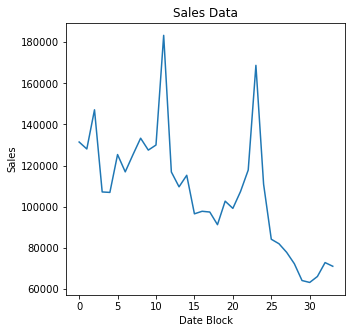

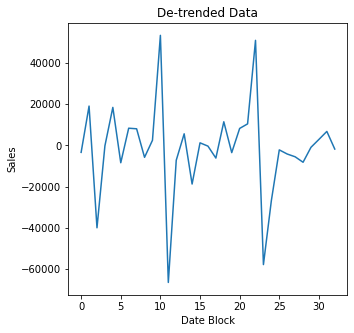

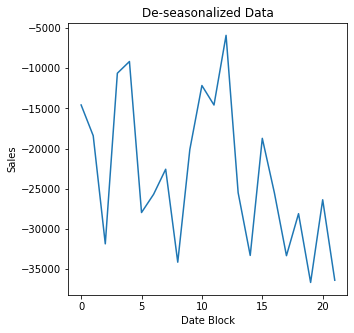

In [16]:
ts_sarima=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts_sarima.astype('float')
plt.figure(figsize=(5,5))
plt.title('Sales Data')
plt.xlabel('Date Block')
plt.ylabel('Sales')
plt.plot(ts_sarima)
plt.show()
plt.figure(figsize=(5,5))
plt.title('De-trended Data')
plt.xlabel('Date Block')
plt.ylabel('Sales')
new_ts=diff_series(ts_sarima)
plt.plot(new_ts)
plt.plot()
plt.show()
plt.figure(figsize=(5,5))
plt.title('De-seasonalized Data')
plt.xlabel('Date Block')
plt.ylabel('Sales')
new_ts=diff_series(ts_sarima,12)   
plt.plot(new_ts)
plt.plot()
plt.show()

In [17]:
stationarity_check(new_ts)

Results of Dickey-Fuller Test:
Test Statistic          -3.270101
p-value                  0.016269
Lags                     0.000000
Size of Data            21.000000
Critical Value (1%)     -3.788386
Critical Value (5%)     -3.013098
Critical Value (10%)    -2.646397
dtype: float64


# Getting Item Categories with 34 Months of Data

In [21]:
sales_cat = pd.merge(sales, item, on = 'item_id', how = 'inner')
sales_cat

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,2013-01-02,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37
1,2013-01-23,0,24,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37
2,2013-01-20,0,27,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37
3,2013-01-02,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37
4,2013-01-03,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37
...,...,...,...,...,...,...,...,...
2935844,2015-10-17,33,25,8428,249.0,1.0,"АХ, ВОДЕВИЛЬ, ВОДЕВИЛЬ (rem)",40
2935845,2015-10-01,33,25,7903,12198.0,1.0,XBOX 360 S 250GB CONSOLE/KINECT BUNDLE KUNG FU...,15
2935846,2015-10-29,33,25,7610,2890.0,1.0,WARHAMMER ACCESSORIES: Khorne Dice арт. 65-13,64
2935847,2015-10-22,33,25,7635,2100.0,1.0,WARHAMMER MINIATURES: Dark Elf Doomfire Warloc...,64


In [22]:
ts_cat = sales_cat.groupby(['date_block_num', "item_category_id"], as_index=False)["item_cnt_day"].sum()
just_dates = list(ts['ds'])
just_dates
date_df = pd.DataFrame({'date_block_num':list(range(0,34)), 'month': just_dates})
ts_cat = pd.merge(ts_cat, date_df, on = 'date_block_num', how = 'inner')
drop_cats = []
dic = Counter(list(ts_cat.item_category_id))
for i in dic.keys():
    if dic[i] == 34:
        drop_cats.append(i)
arima_cats = drop_cats
arima_cats.remove(61)
arima_cats.remove(75)

# ARIMA

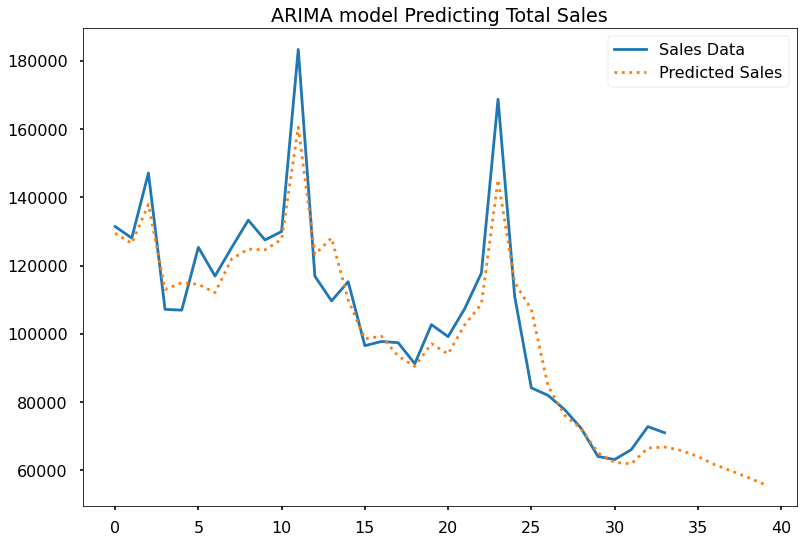

In [38]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts.y, order=(2, 1, 1))
model_fit = model.fit(disp=False)
yhat = model_fit.predict(1, len(ts['y'])+6, typ='levels')

y_vals = ts.y
yhat_vals = list(yhat)
arima_tot_sales = y_vals
plt.style.use('seaborn-poster')
plt.figure()
plt.plot(y_vals, label='Sales Data')
plt.plot(yhat_vals, ls=':', label='Predicted Sales')
plt.legend(loc='best')
plt.title('ARIMA model Predicting Total Sales')
plt.show()

In [ ]:
arima_rms = dict()
for i in arima_cats:
    temp_df = ts_cat.loc[ts_cat.item_category_id == i]
    y_vals = list(temp_df.item_cnt_day)
    model = ARIMA(y_vals, order=(2, 1, 1))
    model = model.fit(disp=False)
    # make prediction
    yhat = model.predict(1, len(ts['y'])+6, typ='levels')
    yhat_vals = list(yhat)
    arima_rms[i] = mean_squared_error(y_vals, yhat_vals[0:34], squared=False)
#     plt.style.use('seaborn-poster')
#     plt.figure()
#     plt.plot(dataList, label='Sales Data')
#     plt.plot(yhatList, ls=':', label='Predicted Sales')
#     plt.legend(loc='best')
#     plt.title('ARIMA model for Category: ' + str(i))
#     plt.show()

# SARIMAX

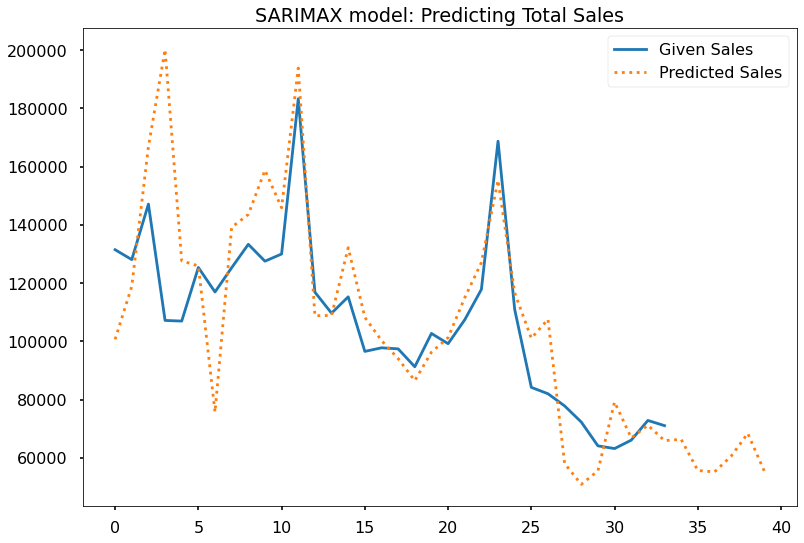

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(ts.y, order=(2,1,2), seasonal_order=(0,1,1,4))
model = model.fit(disp=False)
# make prediction
yhat = model.predict(1, len(list(ts.y))+6)

y_vals = list(ts.y)
yhat_vals = list(yhat)
sarima_tot_sales = y_vals
plt.style.use('seaborn-poster')
plt.figure()
plt.plot(y_vals, label='Given Sales')
plt.plot(yhat_vals, ls=':', label='Predicted Sales')
plt.legend(loc='best')
plt.title('SARIMAX model: Predicting Total Sales')
plt.show()

In [33]:
sarima_rms = dict()
for i in arima_cats:
    temp_df = ts_cat.loc[ts_cat.item_category_id == i]
    y_vals = list(temp_df.item_cnt_day)
    model = SARIMAX(y_vals, order=(2,1,2), seasonal_order=(0,1,1,4))
    model= model.fit(disp=False)
    yhat = model.predict(1, len(list(y_vals))+6)

    yhat_vals = list(yhat)
    sarima_rms[i] = mean_squared_error(y_vals, yhat_vals[0:34], squared=False)


#     plt.style.use('seaborn-poster')
#     plt.figure()
#     plt.plot(dataList, label='Sales Data')
#     plt.plot(yhatList, ls=':', label='Predicted Sales')
#     plt.legend(loc='best')
#     plt.title('SARIMAX model for Category: '+ str(i))
#     plt.show()

# Facebook Prophet

In [27]:
# model = Prophet(yearly_seasonality=True) 
# model.fit(ts)
# future = model.make_future_dataframe(periods = 6, freq = 'MS')  
# forecast = model.predict(future)
# forecast[['ds', 'yhat']]
# plt.style.use('seaborn-poster')
# plt.figure()
# plt.plot(dataList, label='Original')
# plt.plot(forecast['yhat'], ls='--', label="Predicted")
# plt.legend(loc='best')
# plt.title('FB Prophet model')
# plt.show()

In [28]:
# pd.options.mode.chained_assignment = None
# fb_rms = dict()
# for i in arima_cats:
#     temp_df = ts_cat.loc[ts_cat.item_category_id == i]
#     temp_df.drop(['date_block_num', 'item_category_id'], axis=1, inplace=True)
#     temp_df = temp_df[['month', 'item_cnt_day']]
#     temp_df.columns = ['ds', 'y']
    
#     model = Prophet(yearly_seasonality=True) 
#     model.fit(temp_df)
#     future = model.make_future_dataframe(periods = 6, freq = 'MS')  
#     forecast = model.predict(future)
#     forecast[['ds', 'yhat']]
#     fb_rms[i] = mean_squared_error(temp_df.y, forecast['yhat'][:34], squared = False)
# fb_rms
#     plt.style.use('seaborn-poster')
#     plt.figure()
#     plt.plot(list(temp_df['y']), label='Original')
#     plt.plot(forecast['yhat'], ls='--', label="Predicted")
#     plt.legend(loc='best')
#     plt.title('FB Prophet model')
#     plt.show()

In [29]:
fb_tot_sales = [132111.36120030918,
 131029.19300788881,
 148046.3894560704,
 107581.6844476161,
 107336.581032032,
 122945.98286933989,
 113629.82305456258,
 124068.21155665879,
 128923.97484806787,
 127879.37638182657,
 132180.26658920915,
 187020.78294033988,
 119833.10721022506,
 107970.63250609614,
 115795.87524676761,
 95349.36171207986,
 94510.19255921613,
 98348.86872885306,
 93675.20622977443,
 101777.59910160472,
 106062.47438759328,
 106778.69969565459,
 115690.62677732669,
 165082.5703792565,
 107405.86682020307,
 82974.5466671849,
 80584.03279335867,
 78621.36288025934,
 75195.18018896447,
 65618.98677824815,
 64132.48133552814,
 68255.35622647007,
 70408.96011601099,
 71379.14726936107,
 83193.9572396925,
 125513.06295045922,
 75625.68852721663,
 40109.144435565264,
 76664.08467040511,
 14641.973151733859]

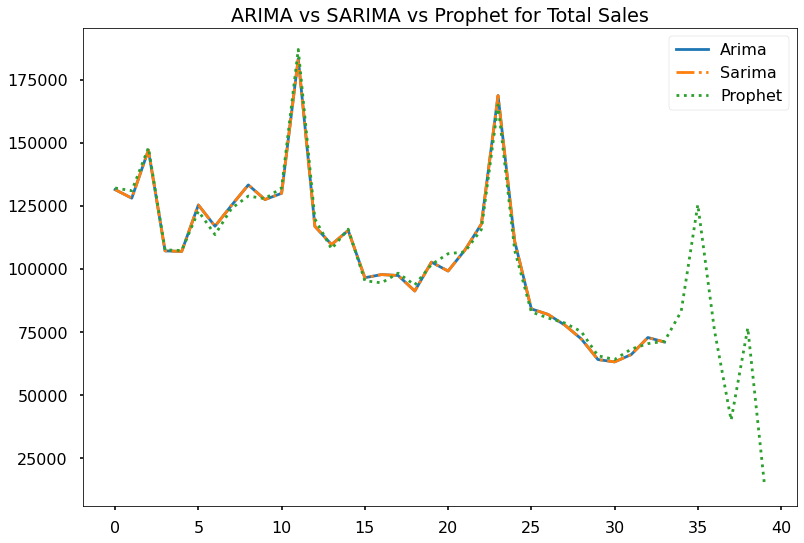

In [41]:
plt.style.use('seaborn-poster')
plt.figure()
plt.plot(arima_tot_sales, label='Arima')
plt.plot(sarima_tot_sales, ls='-.', label='Sarima')
plt.plot(fb_tot_sales, ls=':', label='Prophet')
plt.legend(loc='best')
plt.title('ARIMA vs SARIMA vs Prophet for Total Sales')
plt.show()

In [30]:
fb_rms_vals = [155.0669477378906, 266.29282680428827, 30.615791369832202, 29.192024586107127, 185.22883206588963, 70.34014382953217, 10.494116792870058, 15.264343105031767, 1197.9856443757164, 343.54865994884864, 83.56892072471574, 633.8841219773284, 111.34256251342717, 940.2626455894713, 241.15126218418857, 1146.6248331784934, 71.0878490700654, 261.30209691140817, 650.4544129559843, 99.2486456727392, 482.5766164446801, 125.43492226968813, 28.336435221927243, 16.40178779602193, 39.93074242284164, 415.78520969047287, 80.15532623001752, 38.90877328829453, 36.45667163191549, 5.411909946153223, 172.3276104792987, 377.2105680780324, 68.81814027185455, 250.18439486264646, 173.22591900975408, 131.39177790186415, 344.39870848569063, 1952.0549107904685, 201.11207463834043, 13.650389876542489, 74.73520391554489, 325.8990631935368, 180.40816222592835]
fb_rms = dict()
x = list(arima_rms.keys())

for i in range(0,43):
    fb_rms[x[i]] = fb_rms_vals[i]

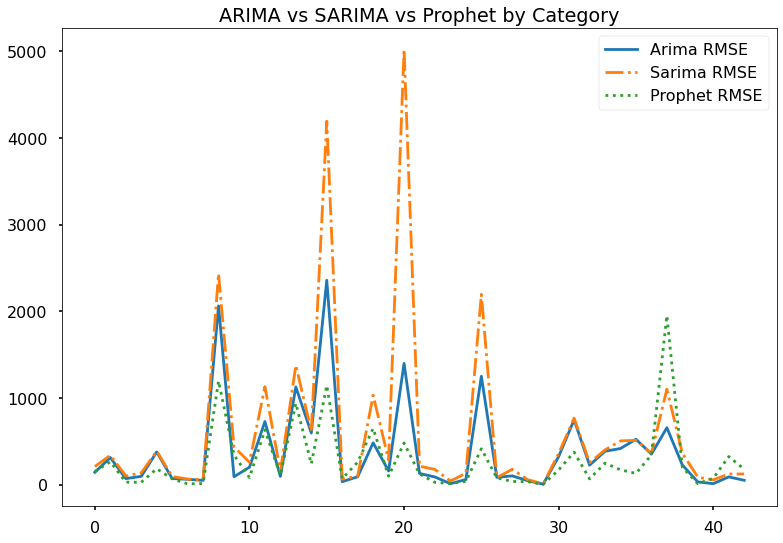

In [36]:
plt.style.use('seaborn-poster')
plt.figure()
plt.plot(list(arima_rms.values()), label='Arima RMSE')
plt.plot(list(sarima_rms.values()), ls='-.', label='Sarima RMSE')
plt.plot(list(fb_rms.values()), ls=':', label='Prophet RMSE')
plt.legend(loc='best')
plt.title('ARIMA vs SARIMA vs Prophet by Category')
plt.show()

# Shops and Items with 34 Months of Data

In [42]:
counter_item_shop = dict(Counter([(i,j) for i,j in zip(main_df.shop_id, main_df.item_id)]))
final_pairs = []
for i in counter_item_shop.keys():
    if counter_item_shop[i] == 34:
        final_pairs.append(i)
all_pairs = [(i,j) for i,j in zip(main_df.shop_id, main_df.item_id)]
main_df['Final Pairs'] = all_pairs
filter_df = main_df[main_df['Final Pairs'].isin(final_pairs)]

In [49]:
len(final_pairs)

102

In [50]:
arima_sip = 0
for i in list(filter_df['Final Pairs']):
    temp_df = filter_df.loc[filter_df['Final Pairs'] == i]
    y_vals = list(temp_df.item_cnt_day)
    model = ARIMA(y_vals, order=(2, 1, 1))
    model = model.fit(disp=False)
    # make prediction
    yhat = model.predict(1, len(ts['y'])+6, typ='levels')
    yhat_vals = list(yhat)
    arima_sip =  arima_sip + mean_squared_error(y_vals, yhat_vals[0:34], squared=False)
arima_sip = arima_sip/len(final_pairs)
#     plt.style.use('seaborn-poster')
#     plt.figure()
#     plt.plot(dataList, label='Sales Data')
#     plt.plot(yhatList, ls=':', label='Predicted Sales')
#     plt.legend(loc='best')
#     plt.title('ARIMA model for Shop Item Pairs: ' + str(i))
#     plt.show()

In [51]:
arima_sip

243.35976032465035

In [52]:
sarima_sip = 0
for i in list(filter_df['Final Pairs']):
    temp_df = filter_df.loc[filter_df['Final Pairs'] == i]
    y_vals = list(temp_df.item_cnt_day)
    model = SARIMAX(y_vals, order=(2,1,2), seasonal_order=(0,1,1,4))

    model = model.fit(disp=False)
    # make prediction
    yhat = model.predict(1, len(ts['y'])+6, typ='levels')
    yhat_vals = list(yhat)
    sarima_sip =  sarima_sip + mean_squared_error(y_vals, yhat_vals[0:34], squared=False)
sarima_sip = sarima_sip/len(final_pairs)

In [53]:
sarima_sip

365.391069339656